# Lesson 2 -- Planet: Understanding the Amazon from Space

In this notebook, we'll try to make an entry into a completed kaggle competition.
[This competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) completed back in July of 2017, but you can still make submissions and have them evaluated and see how you'd do on the leaderboard.

The primary difference between this competition and [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) is that each sample in the dataset can have multiple labels.
For example, a single satellite image can be labeled 'primary', 'clear', and 'agriculture' all at once.
All this requires from us though, in general, is a different final activation function and a different loss function.

The basic approach we take is to fine-tune a resnet34 model that has been pretrained on the imagenet dataset.
At first we will downscale the images to 64x64 (originals are 256x256), for training speed.
Then we will increase the image size in steps up to the original resolution.
Each time we change the resolution we will first freeze the network except for the final classification layers and train only those.
Then we will unfreeze the whole network and train it all with different learning rates for different layers.

### Downloading the Dataset

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com.
Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'.
This will trigger the download of kaggle.json, a file containing your API credentials.

In [1]:
# change to True if you need to download the training data
download_training_data = False

if download_training_data:
    from google.colab import files
    uploaded = files.upload() # Choose your local kaggle.json file

    # move the file into place and update it's permissions
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle
    !chmod 600 ~/.kaggle/kaggle.json

    # install kaggle command line tool and use it to download the planet datset files we need
    !mkdir -p ~/data/planet
    !pip install kaggle
    !kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p ~/data/planet
    !kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv.zip -p ~/data/planet

    # decompress the data
    !apt-get install p7zip-full

    !7za x ~/data/planet/train-jpg.tar.7z -o$HOME/data/planet
    !tar -xf ~/data/planet/train-jpg.tar -C ~/data/planet
    !rm -f   ~/data/planet/train-jpg.*

    !unzip -d ~/data/planet ~/data/planet/train_v2.csv.zip
    !rm -f ~/data/planet/train_v2.csv.zip

### If you're using Google Colab... install dependencies

In [2]:
# change to True if you need to install dependencies
on_google_colab = False

if on_google_colab:
    !pip install --process-dependency-links pytorch-sconce==1.0.2
    !pip install --no-cache-dir -I Pillow==5.0.0
    # You may need to restart the notebook (Menubar: Runtime -> Restart runtime...)

## Imports

In [3]:
# Needed for the f2 metric calculation, but not included in sconce.
!pip install scikit-learn==0.19.1

In [4]:
from IPython.display import FileLink
from sconce.data_generators import MultiClassImageDataGenerator
from sconce.data_generators.base import DataGenerator
from sconce.datasets import UnlabeledImageFolder
from sconce.datasets.csv_image_folder import CsvImageFolder
from sconce.models.base import Model
from sconce.models.layers import AdaptiveAveragePooling2dLayer, Convolution2dLayer, FullyConnectedLayer
from sconce.parameter_group import ParameterGroup
from sconce.schedules import Cosine
from sconce.trainer import Trainer
from sklearn.metrics import fbeta_score
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.models import resnet34

import numpy as np
import os
import sconce
import torch
import warnings

print(f"Notebook was run with pytorch-sconce version: {sconce.__version__}")

Notebook was run with pytorch-sconce version: 1.1.0


## Construct the training and test datasets

Lets make a function to construct the sconce [DataGenerators](https://davidlmorton.github.io/pytorch-sconce/data_generator.html#datagenerator) we will provide to the sconce [Trainer](https://davidlmorton.github.io/pytorch-sconce/trainers.html#sconce.trainer.Trainer) later.  The reason we make this a function, is so that we can create new data generators of different image sizes and resolutions throughout training.

In [5]:
def get_data_generators(image_size, batch_size):
    training_transform = transforms.Compose([
        transforms.Resize(int(image_size*1.15)),
        transforms.RandomAffine(degrees=(0,10), translate=(0.02, 0.02), scale=(1.0, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0], std=[1.0])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0], std=[1.0])
    ])

    base_dir = 'data/planet/'
    dataset = CsvImageFolder(root=base_dir+'train-jpg',
                             csv_path=base_dir+'train_v2.csv',
                             transform=training_transform)
    
    np.random.seed(3)
    training_data_generator, test_data_generator = MultiClassImageDataGenerator.from_dataset(
        dataset=dataset, split=0.8, batch_size=batch_size, shuffle=True,
        num_workers=3 # if using google colab, this needs to be set to 0 (zero).
    )
    
    if torch.cuda.is_available():
        training_data_generator.cuda()
        test_data_generator.cuda()
        
    return training_data_generator, test_data_generator

In [6]:
training_data_generator, test_data_generator = get_data_generators(
    image_size=64, batch_size=128)

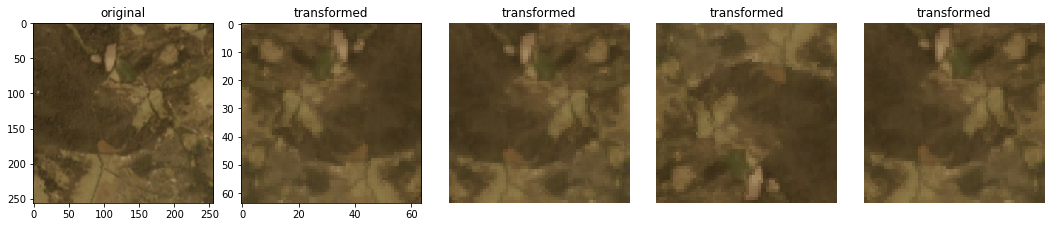

In [7]:
training_data_generator.plot_transforms(index=1111)

### Class Balance

Here we can see that the classes are really unbalanced.  However, in all of my experiments, rebalancing the classes by including images with rare classifications more often in mini-batches resulted in no improvment, or worse, a performance degregation.

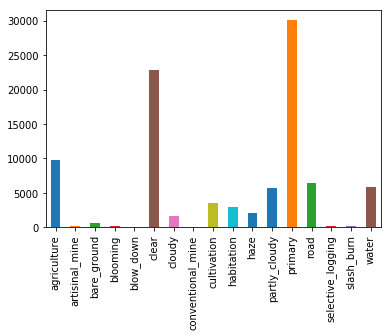

In [8]:
training_data_generator.plot_class_summary();

## Define Model

Here we'll define the sconce [Model](https://davidlmorton.github.io/pytorch-sconce/models.html#sconce.models.Model) that we will train later.
The `__init__` defines the 'new classifier' that replaces the portion of the pretrained resnet34 network that predicted imagenet categories.
Notice that the final activation function here is Sigmoid instead of Softmax.
We do this because the idea is to let the network predict multiple labels per sample.
We specify binary cross entropy for the loss this time, instead of negative log likelyhood loss (from the Dogs vs. Cats competition).
This is also because we don't have mutually exclusive categories.

Finally, the kaggle submission score is based on the f2 score, we'll calculate that as a metric so we can see it during training.

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    

class MyModel(Model):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base_model = base_model
        self.num_classes = num_classes
        
        in_size = base_model.fc.in_features
        mid_size = in_size // 2
        
        self.new_classifier = nn.Sequential(
            AdaptiveAveragePooling2dLayer(in_channels=in_size, output_size=1, inplace_activation=True),
            Flatten(),
            FullyConnectedLayer(in_size=in_size, out_size=mid_size, activation=nn.ReLU(inplace=True)),
            FullyConnectedLayer(in_size=mid_size, out_size=num_classes, activation=nn.Sigmoid()),
        )
        
    def forward(self, inputs, **kwargs):
        # These next 8 lines are from the resnet's `forward` method.
        x = self.base_model.conv1(inputs)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)
        
        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        
        # This replaces the last two lines in the resnet's `forward` method.
        x = self.new_classifier(x)
        return {'outputs': x}
    
    def calculate_loss(self, targets, outputs, **kwargs):
        return {'loss': F.binary_cross_entropy(outputs, targets.view_as(outputs))}

    def calculate_metrics(self, targets, outputs, **kwargs):
        targets = targets.cpu().data.numpy()
        outputs = outputs.cpu().data.numpy()
            
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            # threshold is somewhat arbitrary, but 0.2 has been shown to work well enough.
            threshold = 0.2
            f2 = fbeta_score(y_true=targets, y_pred=(outputs > threshold), beta=2, average='samples')
        
        return {'f2': f2}
    
    
def create_model(model_class=MyModel):
    # Get a resnet model pretrained on imagenet data (will download training weights).
    base_model = resnet34(pretrained=True)
    
    # Freeze all parameters in the network, so they don't get updated during training.
    for param in base_model.parameters():
        param.requires_grad = False
        
    # Replace last fully-connected layer with a little network that outputs what we want.
    # This is now the only part of the model that isn't yet trained.
    num_classes = training_data_generator.dataset.num_classes
    model = model_class(base_model, num_classes=num_classes)
    
    model.set_optimizer(optim.SGD, lr=1e-1, momentum=0.9)
    
    if torch.cuda.is_available():
        model.cuda()

    print(f'Number of trainable parameters: {model.get_num_trainable_parameters()}')
    return model

In [10]:
model = create_model()

trainer = Trainer(model=model,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

Number of trainable parameters: 138257


253/253 [==============================] - 17s 66ms/step - loss: 0.1920


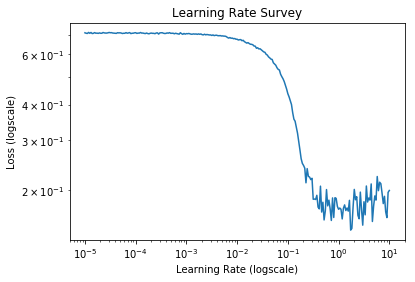

In [11]:
survey_monitor = trainer.survey_learning_rate(
    num_epochs=1,
    min_learning_rate=1e-5,
    max_learning_rate=1e1,
    stop_factor=3)
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

In [12]:
from sconce.schedules import Triangle
trainer.model.set_schedule('learning_rate', Cosine(initial_value=1e-1, final_value=1e-9))
trainer.multi_train(cycle_length=1, num_cycles=3);

1012/1012 [==============================] - 74s 73ms/step - loss: 0.1436 - val_loss: 0.1411


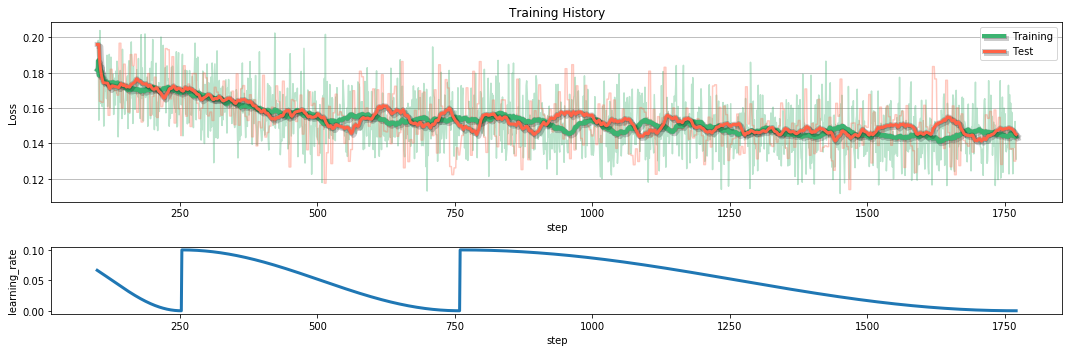

In [13]:
trainer.monitor.dataframe_monitor.plot(skip_first=100);

In [14]:
monitor = trainer.test()
monitor.dataframe_monitor.df.test_f2.mean()

64/64 [==============================] - 4s 68ms/step - loss: 0.1461


0.8670346098441557

## Layerwise Learning Schedules

Now we extend the model we created above to include [ParameterGroups](https://davidlmorton.github.io/pytorch-sconce/parameter_group.html#sconce.parameter_group.ParameterGroup).
This will then allow us to set a learning rate [Schedule](https://davidlmorton.github.io/pytorch-sconce/schedules.html#sconce.schedules.Schedule) on each layer of the network independently.

The idea being that we'd like to preserve the resnet's pretrained weights for early layers, while we train up the 'new classifier' part.
Then, once we have the 'new classifier' trained up, we want to allow the rest of the network to be trained.
However, because the network is pretty well tuned already, we want to train the earlier layers with a lower learning rate than we used to train the 'new classifier' part.
We define here the `freeze` and `unfreeze` functions to allow us to freeze all but the 'new classifier' part.

Note how many parameters we have now (more than 21 million, vs just 140 thousand for the 'new classifier' alone).
Another reason we don't want to turn up the learning rate on all those parameters is that we'd easily overfit, even with the data augmentation we have used.

In [15]:
class MyLayerWiseModel(MyModel):
    def build_parameter_groups(self):
        super().build_parameter_groups()
        nc_parameters = list(self.new_classifier.parameters())
        nc_group = ParameterGroup(parameters=nc_parameters, name='new_classifier')
        self.add_parameter_group(nc_group)
        
        layer4_parameters = list(self.base_model.layer4.parameters())
        layer4_group = ParameterGroup(parameters=layer4_parameters, name='layer4')
        layer4_group.unfreeze()
        self.add_parameter_group(layer4_group)
        
        layer3_parameters = list(self.base_model.layer3.parameters())
        layer3_group = ParameterGroup(parameters=layer3_parameters, name='layer3')
        layer3_group.unfreeze()
        self.add_parameter_group(layer3_group)
        
        layer2_parameters = list(self.base_model.layer2.parameters())
        layer2_group = ParameterGroup(parameters=layer2_parameters, name='layer2')
        layer2_group.unfreeze()
        self.add_parameter_group(layer2_group)
        
        layer1_parameters = (list(self.base_model.layer1.parameters()) +
                             list(self.base_model.conv1.parameters()) +
                             list(self.base_model.bn1.parameters()))
        layer1_group = ParameterGroup(parameters=layer1_parameters, name='layer1')
        layer1_group.unfreeze()
        self.add_parameter_group(layer1_group)
        
def freeze(trainer):
    trainer.model.get_parameter_group('layer1').freeze()
    trainer.model.get_parameter_group('layer2').freeze()
    trainer.model.get_parameter_group('layer3').freeze()
    trainer.model.get_parameter_group('layer4').freeze()
    
def unfreeze(trainer):
    trainer.model.get_parameter_group('layer1').unfreeze()
    trainer.model.get_parameter_group('layer2').unfreeze()
    trainer.model.get_parameter_group('layer3').unfreeze()
    trainer.model.get_parameter_group('layer4').unfreeze()

In [16]:
model = create_model(model_class=MyLayerWiseModel)

trainer = Trainer(model=model,
    training_data_generator=training_data_generator,
    test_data_generator=test_data_generator)

Number of trainable parameters: 21422929


In [17]:
trainer.model.set_schedule('learning_rate', Cosine(initial_value=1e-1, final_value=1e-9))

freeze(trainer)
trainer.multi_train(num_cycles=3);

1012/1012 [==============================] - 75s 74ms/step - loss: 0.1460 - val_loss: 0.1422


127/127 [==============================] - 32s 250ms/step - loss: 0.1946


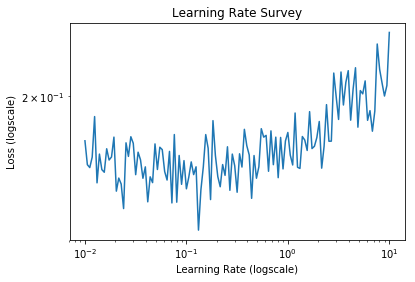

In [18]:
unfreeze(trainer)
survey_monitor = trainer.survey_learning_rate(
    num_epochs=0.5,
    min_learning_rate=1e-2,
    max_learning_rate=1e1,
    stop_factor=3)
survey_monitor.dataframe_monitor.plot_learning_rate_survey()

In [19]:
initial_rate = 1e-1
final_rate = 1e-9
layer_factor = 0.6

for name in ('layer4', 'layer3', 'layer2', 'layer1'):
    initial_rate *= layer_factor
    final_rate *= layer_factor
    
    group = trainer.model.get_parameter_group(name)
    group.set_schedule('learning_rate', Cosine(initial_value=initial_rate,
                                               final_value=final_rate))

In [20]:
trainer.multi_train(num_cycles=3)

1012/1012 [==============================] - 261s 258ms/step - loss: 0.0942 - val_loss: 0.1039


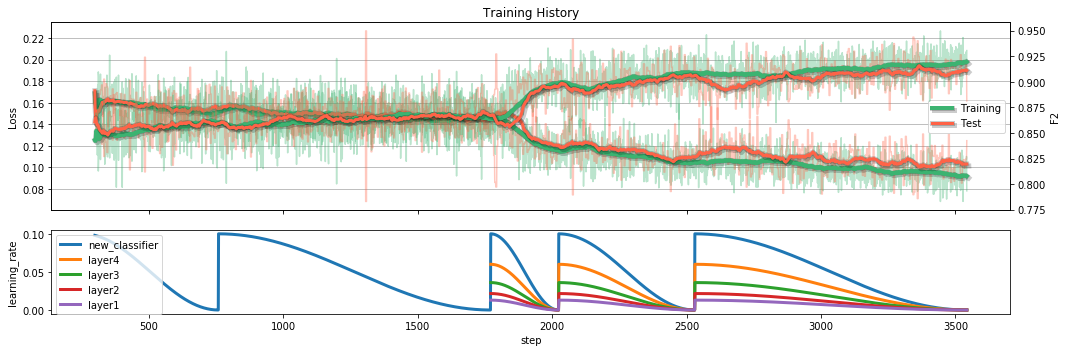

In [21]:
trainer.monitor.dataframe_monitor.plot(skip_first=300, smooth_window=100, metrics=['loss', 'f2']);

In [22]:
monitor = trainer.test()
monitor.dataframe_monitor.df.test_f2.mean()

64/64 [==============================] - 4s 66ms/step - loss: 0.1081


0.9088295093036488

## Up the resolution

Now let's increase the resolution from 64x64 to 128x128.
Again, we'll train just the 'new classifier' part first, then the whole network.

In [23]:
training_data_generator, test_data_generator = get_data_generators(
    image_size=128, batch_size=64)

trainer.training_data_generator = training_data_generator
trainer.test_data_generator = test_data_generator

127/127 [==============================] - 8s 59ms/step - loss: 0.1008


0.90935672636119

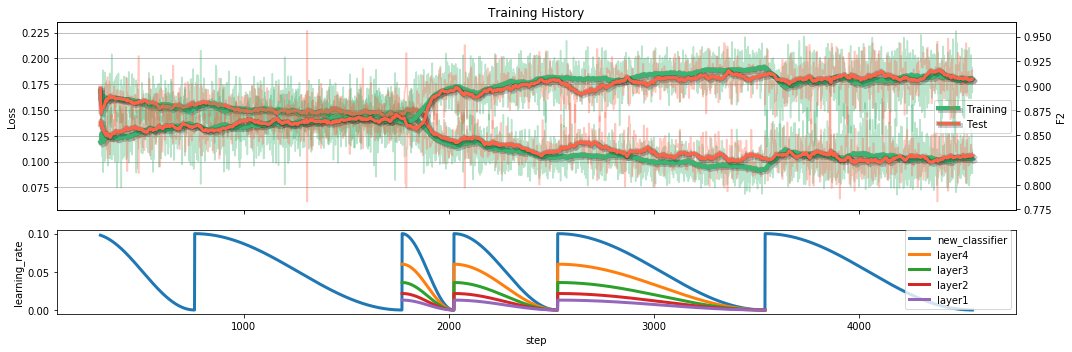

In [24]:
freeze(trainer)

trainer.train(num_epochs=2)
trainer.monitor.dataframe_monitor.plot(skip_first=300, smooth_window=100, metrics=['loss', 'f2'])

monitor = trainer.test()
monitor.dataframe_monitor.df.test_f2.mean()

127/127 [==============================] - 8s 59ms/step - loss: 0.0968


0.917076360346647

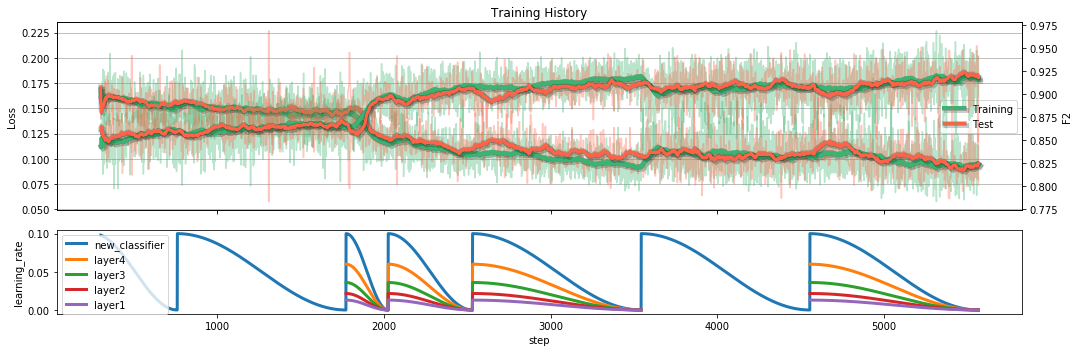

In [25]:
unfreeze(trainer)

trainer.train(num_epochs=2)
trainer.monitor.dataframe_monitor.plot(skip_first=300, smooth_window=100, metrics=['loss', 'f2'])

monitor = trainer.test()
monitor.dataframe_monitor.df.test_f2.mean()

## Up the resolution again

Finally, we'll go to full 256x256 resolution.

In [26]:
training_data_generator, test_data_generator = get_data_generators(
    image_size=256, batch_size=48)

trainer.training_data_generator = training_data_generator
trainer.test_data_generator = test_data_generator

169/169 [==============================] - 24s 144ms/step - loss: 0.0994


0.9128428873104636

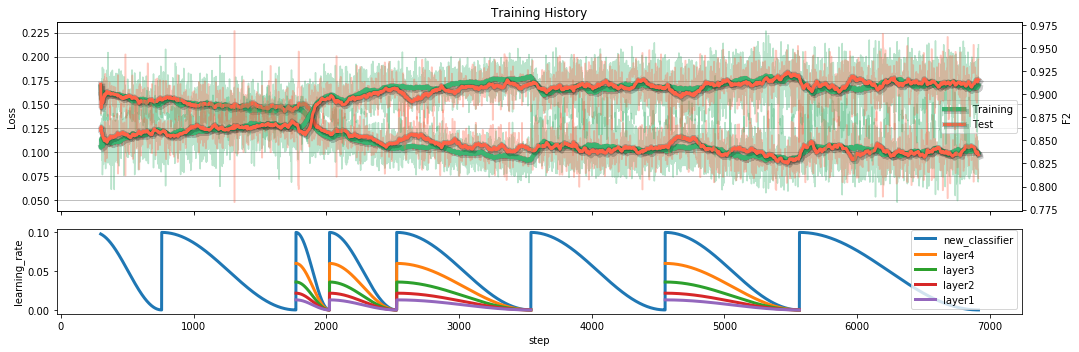

In [27]:
freeze(trainer)

trainer.train(num_epochs=2)
trainer.monitor.dataframe_monitor.plot(skip_first=300, smooth_window=100, metrics=['loss', 'f2'])

monitor = trainer.test()
monitor.dataframe_monitor.df.test_f2.mean()

169/169 [==============================] - 24s 144ms/step - loss: 0.0928


0.9217828944414229

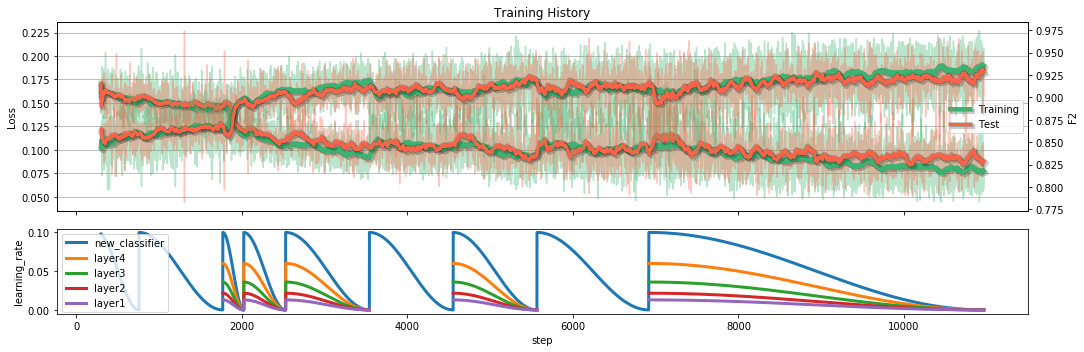

In [28]:
unfreeze(trainer)

trainer.train(num_epochs=6)
trainer.monitor.dataframe_monitor.plot(skip_first=300, smooth_window=100, metrics=['loss', 'f2'])

monitor = trainer.test()
monitor.dataframe_monitor.df.test_f2.mean()

## Submitting to Kaggle

Here we construct the submit.csv file to submit to kaggle.
We need to dowload their test data, and since the competition had a public and a private phase, we have to combine the two datasets.

Just click the link generated to download the file to your local machine.
Then you can submit via their online form [here](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/submit).

In [29]:
# set to True if you need to download the test data
download_kaggle_test_data = False

if download_kaggle_test_data:
    !kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p ~/data/planet

    !7za x ~/data/planet/test-jpg.tar.7z -o$HOME/data/planet
    !tar -xf ~/data/planet/test-jpg.tar -C ~/data/planet
    !rm -f   ~/data/planet/test-jpg.*
    
    !kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p ~/data/planet

    !7za x ~/data/planet/test-jpg-additional.tar.7z -o$HOME/data/planet
    !tar -xf ~/data/planet/test-jpg-additional.tar -C ~/data/planet
    !cp ~/data/planet/test-jpg-additional/*.jpg ~/data/planet/test-jpg
    !rm -f   ~/data/planet/test-jpg-additional.*

In [30]:
planet_classes = np.array(training_data_generator.dataset.classes)
threshold = 0.2
image_size = 256

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])
])

root = 'data/planet/test-jpg'
dataset = UnlabeledImageFolder(root=root, transform=transform)
data_generator = DataGenerator.from_dataset(dataset=dataset, batch_size=48, shuffle=True)
data_generator.cuda({'inputs': 0, 'targets': False})

image_names = []
image_classes = []
data_generator.reset()
for i in range(len(data_generator)):
    inputs, targets = data_generator.next()
    run_dict = trainer._run_model(inputs=inputs, targets=targets, train=False)
    outputs = run_dict['outputs'].cpu().data.numpy()
    
    for target, output in zip(targets, outputs):
        image_name = os.path.splitext(os.path.basename(target))[0]
        image_names.append(image_name)
    
        indices = np.argwhere(output > threshold).T[0]
        strings = sorted(planet_classes[indices])
        image_classes.append(' '.join(strings))
    
with open('submit.csv', 'w') as ofile:
    ofile.write('image_name,tags\n')
    for name, classes in zip(image_names, image_classes):
        ofile.write(f'{name},{classes}\n')
        
FileLink('submit.csv')

/home/davidmorton/git_repos/fastai-course-sconce/submit.csv